In [24]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import random
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import librosa
from scipy.special import softmax

Extract all data

In [25]:
# label mappings
label_map = {"Happiness":"hap",  "Excited":"exc", "Neutral":"neu", "Sadness":"sad", "Anger":"ang", "Surprise":"sur", "Fear":"fea", "Disgust":"dis", "Frustration":"fru", "Other": "oth"}

In [26]:
emotions = ['hap', 'sad', 'ang', 'neu', 'exc', 'fru']
combine = False
name = 'hard'

In [27]:
#emotions = ['ang', 'exc', 'neu', 'sad']
#combine = True # combine hap to exc
#name = 'easy'

In [49]:
pick_prob = 0.4 # probability of picking noisy label if present. Use this to tweak noise %, 1, 0.8, 0.6, 0.4, set it to 1 for easy mode
lb2idx = {lb: idx for idx, lb in enumerate(emotions)}

In [50]:
def get_noisy_label(gt, ce1, ce2, ce3):
    choices = []

    #print("ce1", ce1)
    #print("ce2", ce2)
    #print("ce3", ce3)

    match = re.search(r'\s[\w+;\s?]+\s', ce1)

    if match is not None:
        choices.extend(match.group(0).split())
    
    match = re.search(r'\s[\w+;\s?]+\s', ce2)
    if match is not None:
        choices.extend(match.group(0).split())

    match = re.search(r'\s[\w+;\s?]+\s', ce3)
    if match is not None:
        choices.extend(match.group(0).split())  

    
    filtered_choices = []
    all_choices = []
    #print(choices)
    for choice in choices:
        choice = label_map[re.search('\w+', choice).group(0)]
        if combine and choice == 'hap':
            choice = 'exc'
        if choice in emotions:
            all_choices.append(choice)
            if choice != gt:
                filtered_choices.append(choice)

    soft_gt = np.zeros((len(emotions)))
    for choice in all_choices:
        soft_gt[lb2idx[choice]] += 1

    #print(soft_gt)

    soft_gt = soft_gt/sum(soft_gt)

    #print(soft_gt)

    if len(filtered_choices) == 0:
        return 'none', soft_gt

    noisy_label = random.choice(filtered_choices)
    return noisy_label, soft_gt


def get_comments(ce1, ce2, ce3):
    comments = []

    match = re.search(r'\(.+\)', ce1)
    if match is not None:
        comments.append(match.group(0))

    match = re.search(r'\(.+\)', ce2)
    if match is not None:
        comments.append(match.group(0))

    match = re.search(r'\(.+\)', ce3)
    if match is not None:
        comments.append(match.group(0))
    
    return comments   

In [51]:
from scipy.special import softmax
print(softmax([1, 0, 0]))

[0.57611688 0.21194156 0.21194156]


In [52]:
# number of sessions
n_sess = 5

# to reproduce the same labels
SEED = 6
random.seed(SEED)

PROJ_DIR = os.path.expanduser("~") + "/IEMOCAP_full_release"


def create_dataset(session_id):
    df = pd.DataFrame(columns=['wavfile', 'noisy-label', 'ground-truth', 'soft-gt', 'comments', 'transcript', 'timestamps', 'audio-path'])
    # sample id
    idx = 0
    # paths
    SESSION_DIR = os.path.join(PROJ_DIR, "Session" + str(session_id))
    EVAL_DIR = os.path.join(SESSION_DIR, 'dialog', 'EmoEvaluation')
    AUDIO_DIR = os.path.join(SESSION_DIR, "sentences", "wav")

    durations = []

    # iterate over files present in each session
    for file in os.listdir(EVAL_DIR):
        if file.endswith('.txt'):
            with open(EVAL_DIR + '/' + file, 'rb') as fread: # iterate through lines in the file
                lines = fread.readlines()
                k = 1
                # iterate over utterances
                while k < len(lines):
                    if b'[' in lines[k]:
                        line = lines[k].decode('utf-8')
                        # get audio path
                        match = re.search(r'\bSes\w+\b', line)
                        if match is None:
                            k += 1
                            continue

                        # ground truth label
                        ground_truth =  re.search(r'(hap|neu|fru|exc|oth|dis|xxx|sad|ang|fea|sur)', line).group(0)
                        if ground_truth not in emotions: # we consider only the emotions listed
                            if combine and ground_truth == 'hap':
                                ground_truth = 'exc'
                            else:
                                k += 1
                                continue

                        df.loc[idx, 'wavfile'] = match.group(0)
                        df.loc[idx, 'audio-path'] = AUDIO_DIR + '/' + "_".join(match.group(0).split('_')[:-1]) + '/' + match.group(0) + '.wav'
                        df.loc[idx, 'ground-truth'] = ground_truth

                        
                        # randomly select a noisy label from CE labels
                        ce1 = lines[k+1].decode('utf-8') # Naive Annotator 1
                        ce2 = lines[k+2].decode('utf-8') # Naive Annotator 2
                        ce3 = lines[k+3].decode('utf-8') # Naive Annotator 3

                        noisy_label, soft_gt = get_noisy_label(ground_truth, ce1, ce2, ce3)
                        if noisy_label == "none":
                            df.loc[idx, 'noisy-label'] = ground_truth
                        else:
                            if random.random() <= pick_prob:
                                df.loc[idx, 'noisy-label'] = noisy_label
                            else:
                                df.loc[idx, 'noisy-label'] = ground_truth
                        df.loc[idx, 'soft-gt'] = soft_gt

                        # get annotator comments
                        comments = get_comments(ce1, ce2, ce3)
                        df.loc[idx, 'comments'] = ".".join(comments)

                        # get timestamps
                        match = re.search(r'\[[\d\-\.\s]+\]', line)
                        df.loc[idx, 'timestamps'] = match.group(0)

                        idx += 1
                    k += 1
    return df

# create train set
train_df = pd.DataFrame(columns=['wavfile', 'noisy-label', 'ground-truth', 'comments', 'transcript', 'timestamps', 'audio-path'])
for i in trange(1, 5):
    train_df = pd.concat([train_df, create_dataset(i)])


# create test set
test_df = create_dataset(session_id=5)
    

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


In [53]:
print(train_df)

                     wavfile noisy-label ground-truth comments transcript  \
0        Ses01M_impro02_F000         neu          neu                 NaN   
1        Ses01M_impro02_F003         fru          fru                 NaN   
2        Ses01M_impro02_F004         ang          fru                 NaN   
3        Ses01M_impro02_F005         fru          fru                 NaN   
4        Ses01M_impro02_F006         fru          fru                 NaN   
...                      ...         ...          ...      ...        ...   
1507  Ses04F_script03_1_M027         neu          neu                 NaN   
1508  Ses04F_script03_1_M028         neu          neu                 NaN   
1509  Ses04F_script03_1_M029         exc          neu                 NaN   
1510  Ses04F_script03_1_M030         exc          neu                 NaN   
1511  Ses04F_script03_1_M031         exc          neu                 NaN   

                 timestamps  \
0        [8.0737 - 11.4700]   
1       [35.4

In [54]:
print(test_df)

                  wavfile noisy-label ground-truth  \
0     Ses05M_impro07_F000         neu          exc   
1     Ses05M_impro07_F001         hap          exc   
2     Ses05M_impro07_F003         exc          exc   
3     Ses05M_impro07_F004         exc          hap   
4     Ses05M_impro07_F005         exc          hap   
...                   ...         ...          ...   
1617  Ses05M_impro01_M018         fru          fru   
1618  Ses05M_impro01_M019         ang          fru   
1619  Ses05M_impro01_M020         ang          fru   
1620  Ses05M_impro01_M021         ang          fru   
1621  Ses05M_impro01_M022         fru          fru   

                                                soft-gt comments transcript  \
0                      [0.25, 0.0, 0.0, 0.25, 0.5, 0.0]                 NaN   
1     [0.3333333333333333, 0.0, 0.0, 0.0, 0.66666666...                 NaN   
2     [0.3333333333333333, 0.0, 0.0, 0.0, 0.66666666...                 NaN   
3     [0.6666666666666666, 0.0, 0.0

In [55]:
#print("With xxx labeled samples")
print(classification_report(train_df['ground-truth'], train_df['noisy-label']))

report = classification_report(train_df['ground-truth'], train_df['noisy-label'], output_dict=True)
noise_percentage = round((1 - report['accuracy'])*100, 2)
print(noise_percentage)

#print("Without xxx labeled samples")
#subset_df = train_df[train_df['ground-truth']!='xxx']
#print(classification_report(subset_df['ground-truth'], subset_df['noisy-label']))

train_df.to_csv(name + '-' + str(noise_percentage) + '-train.csv', index=False)
test_df.to_csv(name + '-' + str(noise_percentage) + '-test.csv', index=False)

              precision    recall  f1-score   support

         ang       0.75      0.75      0.75       933
         exc       0.71      0.74      0.72       742
         fru       0.69      0.74      0.72      1468
         hap       0.61      0.64      0.62       452
         neu       0.77      0.72      0.74      1324
         sad       0.86      0.79      0.82       839

    accuracy                           0.74      5758
   macro avg       0.73      0.73      0.73      5758
weighted avg       0.74      0.74      0.74      5758

26.48


In [17]:
durations = []
means = []
sample_rate = 16000
for i in trange(len(full_df)):
    audio_path = full_df.iloc[i]['audio-path']
    (audio, fs) = librosa.core.load(audio_path, sr=sample_rate, mono=True)
    durations.append(librosa.get_duration(y=audio, sr=sample_rate))
    means.append(np.mean(abs(audio)))

100%|██████████| 7380/7380 [00:04<00:00, 1627.74it/s]


In [12]:
print(durations)

[3.39625, 3.2, 2.2725, 3.3249375, 1.5, 3.1299375, 1.2649375, 3.3, 3.2599375, 4.0599375, 2.6899375, 4.9399375, 2.2924375, 3.30175, 3.7599375, 4.3, 2.7149375, 2.4399375, 8.5199375, 2.9225, 2.68, 4.1899375, 1.8299375, 4.425, 8.34, 2.2824375, 4.3899375, 6.68, 3.1899375, 3.5199375, 2.0799375, 3.7599375, 2.07, 5.31, 2.4499375, 2.3363125, 2.98, 2.4799375, 2.2399375, 6.43675, 5.28, 3.0885, 3.7699375, 7.3474375, 4.9399375, 4.8774375, 4.5299375, 3.25, 4.66, 11.4875, 3.1969375, 8.8399375, 9.80825, 6.6654375, 2.170625, 1.911125, 1.8799375, 1.4699375, 3.5825, 5.1478125, 7.0575, 4.6396875, 11.6, 5.7025625, 8.2925, 2.0, 10.619, 4.3325, 7.6309375, 2.8819375, 3.3765625, 8.30475, 5.26125, 4.23, 3.099, 5.09, 6.6399375, 1.4449375, 2.4199375, 4.3474375, 2.86775, 3.10275, 2.5449375, 8.1474375, 8.4325, 9.8325, 4.7124375, 3.466125, 13.865, 4.307375, 2.81, 2.8941875, 4.4619375, 4.502125, 5.3624375, 1.74, 6.7599375, 2.388125, 14.2841875, 14.855, 7.143875, 1.385, 1.6549375, 3.0069375, 3.3685625, 4.332625, 6.7099

In [19]:
print(means)

[0.0051636435, 0.01348855, 0.030455656, 0.04051545, 0.010475517, 0.013609944, 0.0033463303, 0.008498156, 0.009806976, 0.0069877217, 0.0053399876, 0.010057185, 0.004298503, 0.006161489, 0.0037934263, 0.004471589, 0.006216717, 0.005558515, 0.011147694, 0.0073211906, 0.0046261633, 0.0046000625, 0.003587542, 0.0038159145, 0.003619693, 0.0035024986, 0.004562699, 0.0061961063, 0.0035278169, 0.0043503162, 0.0032091178, 0.005322869, 0.005164811, 0.008187617, 0.00390386, 0.0077514215, 0.013770133, 0.05854364, 0.042239837, 0.049850635, 0.03110897, 0.018027296, 0.021452049, 0.13814844, 0.065650865, 0.077787615, 0.10963176, 0.08822682, 0.0719416, 0.09940032, 0.045758303, 0.009398028, 0.013833149, 0.009457127, 0.004298999, 0.0044294572, 0.010633406, 0.020829733, 0.093138345, 0.036030862, 0.030370489, 0.027263967, 0.013299024, 0.008444824, 0.012300424, 0.0059554423, 0.014076999, 0.0065548588, 0.005325537, 0.0059250635, 0.0037874633, 0.011164956, 0.01747711, 0.0076461034, 0.021119397, 0.0074249986, 0

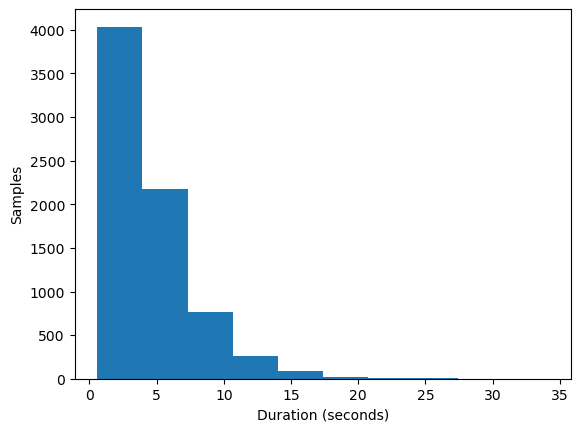

In [13]:
plt.hist(durations, density=False, bins=10)  # density=False would make counts
plt.ylabel('Samples')
plt.xlabel('Duration (seconds)')
plt.savefig('/home/kriti/ambivalent/images/durations.png')

In [14]:
print(re.search(r'\[[\d\-\.]+\]', "yup  [7.4]").group(0))

[7.4]


In [15]:
train_df[:5]

,wavfile,noisy-label,ground-truth,comments,transcript,timestamps,audio-path
0,Ses01M_impro02_F000,neu,neu,,NaN,[8.0737 - 11.4700],/home/kriti/IEMOCAP_full_release/Session1/sent...
1,Ses01M_impro02_F003,fru,fru,,NaN,[35.4000 - 38.6000],/home/kriti/IEMOCAP_full_release/Session1/sent...
2,Ses01M_impro02_F004,fru,fru,,NaN,[40.1000 - 42.3725],/home/kriti/IEMOCAP_full_release/Session1/sent...
3,Ses01M_impro02_F005,ang,fru,,NaN,[42.4950 - 45.8200],/home/kriti/IEMOCAP_full_release/Session1/sent...
4,Ses01M_impro02_F006,fru,fru,,NaN,[53.4950 - 54.9950],/home/kriti/IEMOCAP_full_release/Session1/sent...


In [16]:
test_df[:5]

,wavfile,noisy-label,ground-truth,comments,transcript,timestamps,audio-path
0,Ses05M_impro07_F000,hap,exc,,NaN,[5.4800 - 6.7000],/home/kriti/IEMOCAP_full_release/Session5/sent...
1,Ses05M_impro07_F001,exc,exc,,NaN,[8.3300 - 9.6900],/home/kriti/IEMOCAP_full_release/Session5/sent...
2,Ses05M_impro07_F003,exc,exc,,NaN,[11.3500 - 13.6000],/home/kriti/IEMOCAP_full_release/Session5/sent...
3,Ses05M_impro07_F004,exc,hap,,NaN,[13.9900 - 15.7900],/home/kriti/IEMOCAP_full_release/Session5/sent...
4,Ses05M_impro07_F005,exc,hap,,NaN,[16.3800 - 18.9800],/home/kriti/IEMOCAP_full_release/Session5/sent...


In [17]:
print(len(train_df))
train_df.groupby(['ground-truth'])['wavfile'].count()

5758


ground-truth
ang     933
exc     742
fru    1468
hap     452
neu    1324
sad     839
Name: wavfile, dtype: int64

In [18]:
print(len(full_df))
full_df.groupby(['noisy-labels'])['wavfile'].count()

7380


KeyError: 'noisy-labels'

In [ ]:
print(len(train_df))
train_df.groupby(['ground-truth'])['wavfile'].count()

5758


ground-truth
ang     933
exc     742
fru    1468
hap     452
neu    1324
sad     839
Name: wavfile, dtype: int64

In [ ]:
full_df = pd.concat([train_df,test_df])
full_df

In [ ]:
print(len(train_df))
print(len(test_df))

5758
1622


In [ ]:

packed_hdf5_path = os.path.join('/home/kriti/train.csv', 'features', 'waveform.h5')
with h5py.File(packed_hdf5_path, 'w') as hf:
    for n in trange(audios_num):
        audio_name = meta_dict['audio_name'][n]
        print(audio_name)
        fold = meta_dict['fold'][n]
        audio_path = meta_dict['audio_path'][n]
        print(audio_path)
        print(sample_rate)
        (audio, fs) = librosa.core.load(audio_path, sr=None, mono=True)

FileNotFoundError: [Errno 2] No such file or directory: 'images/global_trust.png'

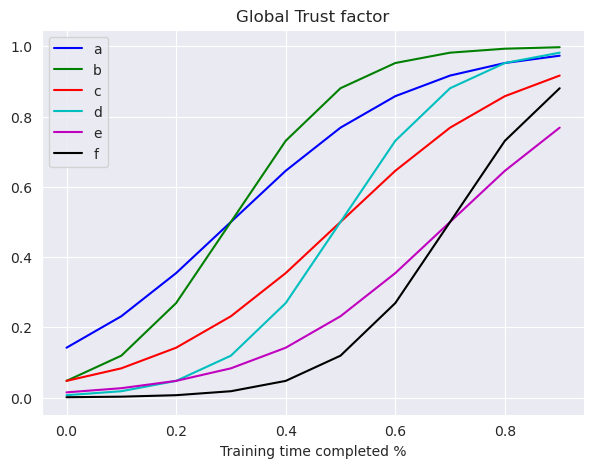

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

theta = 0.3
exp_base = 6
x = np.arange(0, 1, 0.1)
y = 1 / (1 + np.exp(- exp_base * (x - theta)))

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(7, 5))
ax.plot(x, y, 'b')

theta = 0.3
exp_base = 10
x = np.arange(0, 1, 0.1)
y = 1 / (1 + np.exp(- exp_base * (x - theta)))
ax.plot(x, y, 'g')

theta = 0.5
exp_base = 6
x = np.arange(0, 1, 0.1)
y = 1 / (1 + np.exp(- exp_base * (x - theta)))
ax.plot(x, y, 'r')

theta = 0.5
exp_base = 10
x = np.arange(0, 1, 0.1)
y = 1 / (1 + np.exp(- exp_base * (x - theta)))
ax.plot(x, y, 'c')

theta = 0.7
exp_base = 6
x = np.arange(0, 1, 0.1)
y = 1 / (1 + np.exp(- exp_base * (x - theta)))
ax.plot(x, y, 'm')

theta = 0.7
exp_base = 10
x = np.arange(0, 1, 0.1)
y = 1 / (1 + np.exp(- exp_base * (x - theta)))
ax.plot(x, y, 'k')

ax.set_title('Global Trust factor')
ax.set(xlabel='Training time completed %')
ax.legend(labels=['a', 'b', 'c', 'd', 'e', 'f'])
plt.savefig('/home/kriti/ambivalent/images/global_trust.png')

